In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 924.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=12cf6a311afa9711d2c1728918cd2b7091f6d03e703889809f2510018000bbc7
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


### Reading cleaned data

In [2]:
df_tweets = pd.read_csv("../input/tweet-mental-health-classification/train.csv")
df_tweets.shape

(29992, 2)

### Make the labels numeric

In [3]:
mapper = {
    "Anxious": 0,
    "Normal": 1,
    "Stressed": 2,
    "Lonely": 3
}

df_tweets["labels"] = df_tweets["labels"].map(mapper)

### Now lets build a BERT model

In [4]:
from transformers import AutoTokenizer, TFBertModel

tc = AutoTokenizer.from_pretrained("bert-base-uncased",padding_side="left",truncation_side="right",return_tensors="tf")
BERTmodel = TFBertModel.from_pretrained("bert-base-uncased")


2022-08-05 15:32:31.253249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:32:31.254623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:32:31.255329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:32:31.257275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Splitting the data into train and test 

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_tweets,train_size=0.75,random_state=2)

### Step 1 tokenize the training data

In [6]:
import tensorflow as tf
train_tweets = df_train["tweets"].tolist()
test_tweets = df_test["tweets"].tolist()

#### Get the number of the batches 
def num_batches(total,batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1
    
### Tokenize the data function in batches to prevent memory overflow    
def tokenize_text_batches(text,seq_len,batch_size=300):
    total = len(text)
    batches = num_batches(total,batch_size)
    input_ids = np.zeros((total,seq_len))
    token_type_ids = np.zeros((total,seq_len))
    attention_mask = np.zeros((total,seq_len))
    for b in range(batches):
        if total % batch_size == 0 or b < batches -1:
            tokens = tc(text[b*batch_size: b*batch_size + batch_size],max_length=seq_len,padding=True,truncation=True)
            input_ids[b*batch_size:b*batch_size+batch_size,:] = (tokens["input_ids"] )
            token_type_ids[b*batch_size:b*batch_size+batch_size,:] = (tokens["token_type_ids"] )
            attention_mask[b*batch_size:b*batch_size+batch_size,:] = (tokens["attention_mask"] )
            
        else:
            tokens = tc(text[b*batch_size:],max_length=seq_len,padding=True,truncation=True)
            input_ids[b*batch_size:,:] =(tokens["input_ids"] )
            token_type_ids[b*batch_size:,:] = (tokens["token_type_ids"] )
            attention_mask[b*batch_size:,:] = (tokens["attention_mask"] )
            
    return input_ids, token_type_ids, attention_mask
            

### Deciding the optimum sequence length

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tweets', ylabel='Density'>

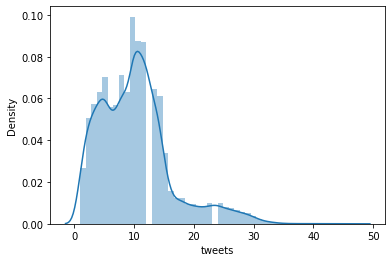

In [7]:
words = df_train["tweets"].apply(lambda x: len(x.split()))
sns.distplot(words)

In [8]:
np.quantile(words,0.8)

14.0

### We will select 15 words as sequence length that is close to 80th percentile

In [9]:
train_inputs = tokenize_text_batches(train_tweets,25,batch_size=300)
test_inputs = tokenize_text_batches(test_tweets,25,batch_size=300)

### Preparing labels

In [10]:
def prepare_labels(labels):
    return pd.get_dummies(labels).values

train_labels = prepare_labels(df_train["labels"])
test_labels = prepare_labels(df_test["labels"])

### Data Is prepared
### Now let us build a model

In [11]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input


In [12]:
test_labels[:10,:]

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [13]:
from tensorflow.keras.layers import Reshape
import keras.backend as K

input_ids = Input(25,dtype=np.int64)
token_type_id = Input(25,dtype=np.int64)
attention_mask = Input(25,dtype=np.int64)
bert_out = BERTmodel(input_ids,token_type_id,attention_mask)

y = Dense(4,activation="softmax",input_shape=(768,))(bert_out.last_hidden_state[:,0,:])
#dense_out = dense
# dropout = Dropout(0.2)
# dp = dropout(dense)
# pred_layer = Dense(4,activation="softmax")
# y = pred_layer(dense)
model = Model([input_ids,token_type_id,attention_mask],y)
model.compile(loss="categorical_crossentropy",metrics="categorical_accuracy",optimizer=tf.keras.optimizers.Adam(2e-6))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

In [14]:
history = model.fit(list(train_inputs),train_labels,batch_size=500,epochs=18,validation_data=(list(test_inputs),test_labels))

2022-08-05 15:33:27.288422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/18
45/45 [==============================] - 81s 1s/step - loss: 1.3570 - categorical_accuracy: 0.3401 - val_loss: 1.2316 - val_categorical_accuracy: 0.4318
Epoch 2/18
45/45 [==============================] - 64s 1s/step - loss: 1.1803 - categorical_accuracy: 0.4568 - val_loss: 1.0521 - val_categorical_accuracy: 0.5051
Epoch 3/18
45/45 [==============================] - 64s 1s/step - loss: 1.0241 - categorical_accuracy: 0.5270 - val_loss: 0.9229 - val_categorical_accuracy: 0.5667
Epoch 4/18
45/45 [==============================] - 64s 1s/step - loss: 0.9136 - categorical_accuracy: 0.5799 - val_loss: 0.8253 - val_categorical_accuracy: 0.6135
Epoch 5/18
45/45 [==============================] - 64s 1s/step - loss: 0.8184 - categorical_accuracy: 0.6163 - val_loss: 0.7675 - val_categorical_accuracy: 0.6319
Epoch 6/18
45/45 [==============================] - 64s 1s/step - loss: 0.7576 - categorical_accuracy: 0.6394 - val_loss: 0.7342 - val_categorical_accuracy: 0.6440
Epoch 7/18
45/45

Text(0, 0.5, 'Accuracy')

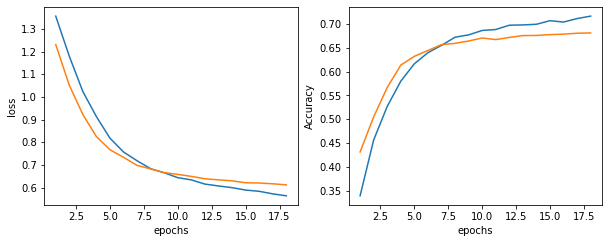

In [15]:
h = history.history
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(range(1,19),h["loss"])
plt.plot(range(1,19),h["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2,2,2)
plt.plot(range(1,19),h["categorical_accuracy"])
plt.plot(range(1,19),h["val_categorical_accuracy"])
plt.xlabel("epochs")
plt.ylabel("Accuracy")

### Training is better predict on test data

In [16]:
predictions = model.predict(test_inputs)
predictions = np.argmax(predictions,axis=1)

In [17]:
from sklearn.metrics import confusion_matrix,classification_report

cf = confusion_matrix(df_test["labels"],predictions)
print(cf)
print(classification_report(df_test["labels"],predictions))

[[1189   91   46  795]
 [ 114 1736   49   59]
 [  51   98 1529   15]
 [ 987   59   30  650]]
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      2121
           1       0.88      0.89      0.88      1958
           2       0.92      0.90      0.91      1693
           3       0.43      0.38      0.40      1726

    accuracy                           0.68      7498
   macro avg       0.68      0.68      0.68      7498
weighted avg       0.68      0.68      0.68      7498



### Save the model 
### Better f1 compared to others

In [18]:
model.save("model-tuned.h5")

In [19]:
df_train

,tweets,labels
28666,oh im hard time cant stop thinking grandpa gra...,2
10458,sad god may soul rest peace forgive perpetrato...,2
7495,igbo diaspora incredibly sophisticated excelle...,2
5886,tw gaslighting abuse ra want share story hope ...,0
6137,love ops,1
...,...,...
18898,final 6 month tatmrparody production involve l...,1
11798,hahha get u soloq need carry eve,0
6637,tw capslock attention new one hehehe hello guy...,0
2575,sighs dream wa party toilet andu lose underwea...,1
